# SentencePiece 사용하기

## Step 1. SentencePiece 설치하기

SentencePiece는 SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다. 아래 링크의 페이지에서 상세한 내용을 파악할 수 있습니다.

* [google/sentencepiece](https://github.com/google/sentencepiece)

In [1]:
# %pip install sentencepiece

In [2]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sentencepiece

%matplotlib inline

## Step 2. SentencePiece 모델 학습

In [3]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

`tokenize()` 함수는 위와 같이 `tf.keras.preprocessing.text.Tokenizer`에 corpus를 주고 `tokenizer.fit_on_texts(corpus)`을 하면 토크나이저 내부적으로 단어사전과 토크나이저 기능을 corpus에 맞춤형으로 자동 생성해 주는 것입니다

In [4]:
# 데이터 다운로드
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [5]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

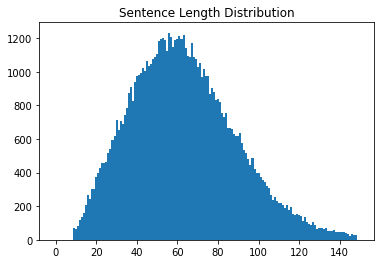

In [6]:
# 분포도를 다시 그려봅니다.
import numpy as np

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [7]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 376892 Oct  5 06:25 korean_spm.model
-rw-r--r-- 1 root root 146388 Oct  5 06:25 korean_spm.vocab


위 코드를 실행하면 정상적으로 SentencePiece 모델 학습이 완료된 후 `korean_spm.model` 파일과 `korean_spm.vocab` vocabulary 파일이 생성되었음을 확인할 수 있습니다.

In [8]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1244, 11, 306, 7, 3599, 11, 286, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## Step 3. Tokenizer 함수 작성

우리는 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의할 겁니다. 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵습니다. 그러니 아래 조건을 만족하는 함수를 정의하도록 하겠습니다.

- 1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

- 2) 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

- 3) 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

In [9]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [10]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1949 5662    5    4 7975 1983    3    0    0    0    0    0    0    0]
 [ 107 1638  101    4    0  419   11    4   14    0 1969    3    3    3]]


## Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

[네이버 영화리뷰 감정 분석 태스크](https://github.com/e9t/nsmc/)

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

### 4.1 데이터 로드하기

In [11]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings_train.txt")

('ratings_train.txt', <http.client.HTTPMessage at 0x7fa3cec83f10>)

In [12]:
import pandas as pd

data = pd.read_table('ratings.txt')
print('리뷰 개수 :',len(data))

리뷰 개수 : 200000


In [39]:
data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


### 4.2 데이터 전처리하기

In [42]:
print(data.isnull().sum()) # NULL 값 존재

id          0
document    8
label       0
dtype: int64


In [43]:
data.loc[data.document.isnull()]

,id,document,label
46471,6369843,NaN,1
60735,511097,NaN,1
77665,2172111,NaN,1
84098,402110,NaN,1
127017,5942978,NaN,0
172375,5026896,NaN,0
173526,1034280,NaN,0
197279,1034283,NaN,0


In [44]:
data = data.dropna(how='any') # Null값이 존재하는 행 제거
print(data.isnull().values.any()) # Null값이 존재하는지 확인

False


In [46]:
min_len = 999
max_len = 0
sum_len = 0

for sen in data.document:
    length = len(str(sen))
#     print(length)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(data.document))

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 35


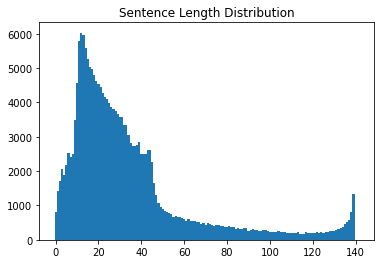

In [47]:
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in data.document:
    sentence_length[len(str(sen))-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [48]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

In [54]:
check_sentence_with_length(data.document, 1)

굿
핡
굿
굿
휴
짱
굿
굿
시
ㅋ
긋
우
ㅇ
굿
굿
굿
굿
굿
굳
짱
갑
꿈
굿
ㅎ
굿
넌
짱
굿
점
점
올
굿
헷
굿
굿
짱
짱
ㅆ
굿
짱
짱
굿
굿
굿
굿
굿
굳
굿
짱
굳
굿
점
잼
굿
짱
굳
굿
굿
굳
ㅎ
굿
아
굿
굿
ㅁ
굳
굿
점
짱
굿
ㅎ
굿
굿
굿
짱
ㅇ
굿
ㅋ
애
짱
굿
점
ㅋ
굿
짱
흠
굿
ㅋ
점
굿
찜
굳
굿
굳
짱
짱
짱
짱
굿
굿
짱


In [55]:
check_sentence_with_length(data.document, 4)

살이엇냐
ㅇㅋㅇㅋ
의 명작
좋은데요
완전 굿
진짜대박
사랑해요
완전 짱
쨩ㅎㅎㅎ
섬세하다
재미잇다
재밋네요
재밋는데
좋은영화
완전추천
준기니깐
최고였지
벡비최고
강인구속
질질싼다
가야지 
잼있어요
훈훈하군
강풀 짱
대작이다
민아 굿
보고잡다
행복수행
디게웃겨
재밋는데
보고싶다
좋은영화
오마이갓
대박 쩜
재미있다
재밌있다
재밌다 
짱이야요
벽속에서
좋습니다
웃긴영화
멋진영화
멋집니다
진짜 짱
재미있다
오왕 굳
재밌네요
조니뎁 
좋아좋아
괜찮던데
천만에요
재밌는데
시대정신
잼있네요
아련돋네
아름답다
짱이쁘요
최고였다
멋져부러
잼났어요
재밋어요
감동영화
재미잇음
재밌었던
완벽하다
연걸사마
재밌던데
재밋어옂
알렉산더
카밀라벨
재미있음
잼나잼나
굿이군요
재밌어요
ㅈㅐ밋따
점 만점
따뜻하다
재미있음
재밌었다
최고였다
재밋네요
꼭 봐라
난좋은데
ㅋㅋ 굿
재밋어요
재밋엇음
연장 고
명작이다
후덜덜등
재밋네요
알이즈웰
하균앓이
최고 ㅋ
괜찮네 
픽사는닥
흥미진진
재미있음
그럭저럭
좋은영화
좋습니다
눈물난다


길이가 1인 문장을 보니 특수문자나 숫자등의 노이즈 데이터들이 있다. 특수문자 및 중복된 데이터를 제거 해준다.

In [51]:
# 한글과 공백을 제외하고 모두 제거
data['document'] = data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [53]:
data['document'] = data['document'].str.replace('^ +', "") # 빈칸 데이터를 empty value로 변경
data['document'].replace("", np.nan, inplace=True)
data = data.dropna(how='any')
print(len(data))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


198315


In [58]:
print(data['document'].nunique(), data['label'].nunique())

190994 2


In [60]:
data.drop_duplicates(subset=['document'], inplace=True) # document열에서 중복인 내용이 있다면 중복 제거

In [61]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 190994


### 4.2 모델 학습하기 
네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기

In [62]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in data.document:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 377844 Oct  5 07:17 korean_spm.model
-rw-r--r-- 1 root root 147376 Oct  5 07:17 korean_spm.vocab


### 4.3 토큰화
학습된 모델로 sp_tokenize() 메소드 구현하기

In [63]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [64]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['영화 진짜 재미없다', '이런 명작을 만날 수 있어 기뻐요']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[ 218  909 4849  299  136 7997   38    0    0]
 [1133  599  641    5 4176   30  831 7223  520]]


In [69]:
X_train, X_train_word_index, X_train_index_word = sp_tokenize(s, data['document'])

In [71]:
y_train = data['label']

### 4.4 훈련, 검증 데이터 분리

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
X_tain[:5]

In [ ]:
y_train[:5]

### 4.5 LSTM으로 감성 분류하기

In [73]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [74]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [75]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [76]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2038/2038 [==============================] - 60s 28ms/step - loss: 0.6935 - acc: 0.5014 - val_loss: 0.6932 - val_acc: 0.5020

Epoch 00001: val_acc improved from -inf to 0.50198, saving model to best_model.h5
Epoch 2/15
2038/2038 [==============================] - 57s 28ms/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5020

Epoch 00002: val_acc did not improve from 0.50198
Epoch 3/15
2038/2038 [==============================] - 57s 28ms/step - loss: 0.6933 - acc: 0.4956 - val_loss: 0.6932 - val_acc: 0.5020

Epoch 00003: val_acc did not improve from 0.50198
Epoch 4/15
2038/2038 [==============================] - 57s 28ms/step - loss: 0.6933 - acc: 0.5025 - val_loss: 0.6934 - val_acc: 0.4980

Epoch 00004: val_acc did not improve from 0.50198
Epoch 5/15
2038/2038 [==============================] - 57s 28ms/step - loss: 0.6933 - acc: 0.4975 - val_loss: 0.6932 - val_acc: 0.4980

Epoch 00005: val_acc did not improve from 0.50198
Epoch 6/15
2038/2038 [===========

In [77]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1194/1194 [==============================] - 10s 8ms/step - loss: 0.6932 - acc: 0.4998

 테스트 정확도: 0.4998


### 4.6 성능 비교하기
KoNLPy 형태소 분석기를 사용한 모델과의 성능 비교

In [79]:
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### 토큰화

In [80]:
# KoNLPy의 Okt를 사용하여 토큰화
okt = Okt()
okt.morphs('이런 명작을 만날 수 있어 기뻐요', stem = True)

['이렇다', '명작', '을', '만날', '수', '있다', '기쁘다']

In [85]:
X_train = []
for sentence in data['document']:
    X_train.append(okt.morphs(sentence, stem=True)) # 토큰화

print(X_train[:3])

[['어리다', '때', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ'], ['디자인', '을', '배우다', '학생', '으로', '외국', '디자이너', '와', '그', '들', '이', '일군', '전통', '을', '통해', '발전', '하다', '문화', '산업', '이', '부럽다', '사실', '우리나라', '에서도', '그', '어렵다', '시절', '에', '끝', '까지', '열정', '을', '지키다', '노라노', '같다', '전통', '이', '있다', '저', '와', '같다', '사람', '들', '이', '꿈', '을', '꾸다', '이루다', '나가다', '수', '있다', '것', '에', '감사하다'], ['폴리스스토리', '시리즈', '는', '부터', '뉴', '까지', '버리다', '하나', '도', '없다', '최고']]


#### 인코딩

In [86]:
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # 각 단어에 고유 정수 부여
print(tokenizer.word_index)

{'이': 1, '영화': 2, '보다': 3, '하다': 4, '의': 5, '에': 6, '가': 7, '을': 8, '도': 9, '들': 10, '는': 11, '를': 12, '은': 13, '없다': 14, '이다': 15, '있다': 16, '좋다': 17, '너무': 18, '다': 19, '정말': 20, '한': 21, '되다': 22, '적': 23, '만': 24, '재밌다': 25, '진짜': 26, '같다': 27, '으로': 28, '로': 29, '아니다': 30, '않다': 31, '점': 32, '에서': 33, '만들다': 34, '나오다': 35, '과': 36, '연기': 37, '평점': 38, '것': 39, '내': 40, '그': 41, '최고': 42, '나': 43, '인': 44, '안': 45, '생각': 46, '못': 47, '스토리': 48, '왜': 49, '드라마': 50, '게': 51, '사람': 52, '감동': 53, '보고': 54, '이렇다': 55, '고': 56, '말': 57, '더': 58, '때': 59, '아깝다': 60, '배우': 61, '와': 62, 'ㅋㅋ': 63, '감독': 64, '아': 65, '거': 66, '그냥': 67, '요': 68, '재미있다': 69, '내용': 70, '재미': 71, '시간': 72, '까지': 73, '중': 74, '주다': 75, '뭐': 76, '자다': 77, '좀': 78, '하고': 79, '지루하다': 80, '수': 81, '재미없다': 82, '네': 83, '쓰레기': 84, '가다': 85, '들다': 86, '모르다': 87, '그렇다': 88, '싶다': 89, '사랑': 90, '지': 91, '작품': 92, '알다': 93, '다시': 94, '하나': 95, '볼': 96, '마지막': 97, '잘': 98, '정도': 99, '저': 100, '이건': 101, 'ㅠㅠ': 102, '오다': 103,

#### 패딩

리뷰의 최대 길이 : 78
리뷰의 평균 길이 : 13.280113511419207


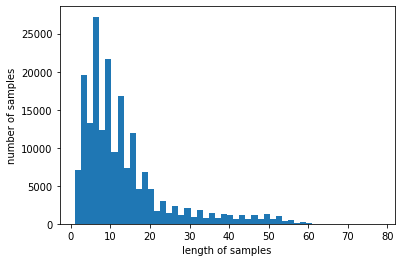

In [87]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [88]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [89]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 91.24998691058359


In [92]:
X_train2 = pad_sequences(X_train, maxlen = max_len)

ValueError: invalid literal for int() with base 10: '어리다'

In [90]:
y_train2 = data['label']

ValueError: invalid literal for int() with base 10: '어리다'

#### 모델학습

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train2, y_train2, test_size=0.2, random_state=42)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train2, y_train2, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test2, y_test2)[1]))

- KoNLPy의 Okt를 이용한 토큰화는 senetencepiece와 비교하여 상당히 오래걸리는 편

## 루브릭

|평가문항|상세기준|
|:---|:---|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.|